In [1]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)

sys.path.insert(1, '/home/zcapjru/PhD/DEScls')

from xcell.mappers import MapperDESY1gc
from astropy.io import fits
from astropy.table import Table

import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp
import os

In [2]:
# Initialize binning scheme with 20 ells per bandpower
nside = 256
ells = []
i = 11.5
while i <= 3 * nside:
    ells.append(round(i))
    #i = i*(1+i/(3 * nside))
    i = i+20*(1+i/240)

bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

In [3]:
DES_1_config = {'data_catalogs':'/home/zcapjru/PhD/Data/DES_redm/DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits', 
                'file_mask':'/home/zcapjru/PhD/Data/DES_redm/DES_Y1A1_3x2pt_redMaGiC_MASK_HPIX4096RING.fits',
                'file_nz':'/home/zcapjru/PhD/Data/DES_redm/2pt_NG_mcal_1110.fits',
          'bin':1,
          'nside':nside, 
          'mask_name': 'mask_DESgc_1'}

DES_2_config = {'data_catalogs':'/home/zcapjru/PhD/Data/DES_redm/DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits', 
                'file_mask':'/home/zcapjru/PhD/Data/DES_redm/DES_Y1A1_3x2pt_redMaGiC_MASK_HPIX4096RING.fits',
                'file_nz':'/home/zcapjru/PhD/Data/DES_redm/2pt_NG_mcal_1110.fits',
          'bin':2,
           'mask_name': 'mask_DESgc_2',
          'nside':nside }

In [4]:
DES_1_maps = MapperDESY1gc(DES_1_config)
DES_2_maps = MapperDESY1gc(DES_2_config)

In [5]:
DES_nz_1 = DES_1_maps.get_nz()
DES_z_1 = DES_nz_1[0]
DES_dNdz_1 = DES_nz_1[1]

DES_nz_2 = DES_2_maps.get_nz()
DES_z_2 = DES_nz_2[0]
DES_dNdz_2 = DES_nz_2[1]

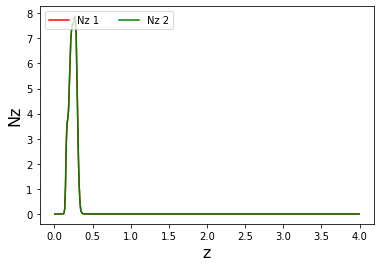

In [6]:
plt.plot(DES_z_1, DES_dNdz_1, 'r-', label='Nz 1')
plt.plot(DES_z_1, DES_dNdz_1, 'g-', label='Nz 2')

plt.xlabel('z', fontsize=16)
plt.ylabel('Nz', fontsize=16)
plt.legend(loc='upper left', ncol=2, labelspacing=0.1)
plt.show()

In [7]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
biases = {
    'b1': 1.41,
    'b2': 1.60,
    'b3': 1.60,
    'b4': 1.91,
    'b5': 1.96 
}

b1 = biases['b1']*np.ones(len(DES_z_1))
DES_gc1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(DES_z_1,DES_dNdz_1), bias=(DES_z_1,b1))
b2 = biases['b2']*np.ones(len(DES_z_2))
DES_gc2 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(DES_z_2,DES_dNdz_2), bias=(DES_z_2,b2))

In [8]:
DES_theory_11 = ccl.angular_cl(cosmo, DES_gc1, DES_gc1, ell_arr) 
DES_theory_12 = ccl.angular_cl(cosmo, DES_gc1, DES_gc2, ell_arr) 

In [9]:
# Read healpix maps and initialize a spin-0 and spin-2 field
DES_mask_1  = DES_1_maps.get_mask()
DES_signal_1 = DES_1_maps.get_signal_map()
DES_mask_2  = DES_2_maps.get_mask()
DES_signal_2 = DES_2_maps.get_signal_map()

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

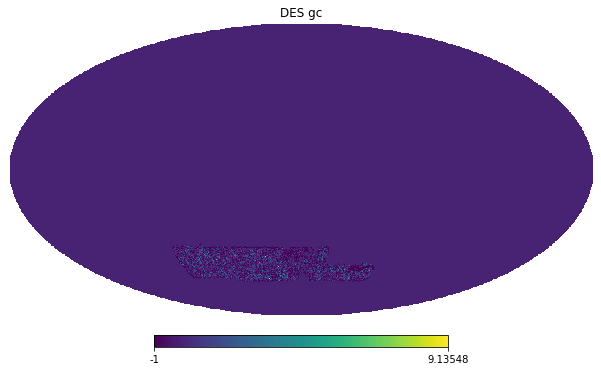

In [10]:
hp.visufunc.mollview(DES_signal_1[0], title= 'DES gc')

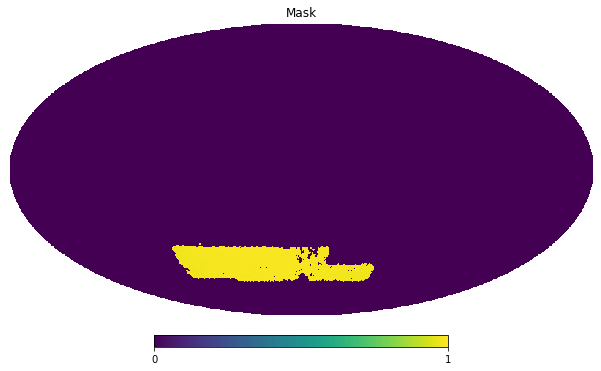

In [11]:
hp.visufunc.mollview(DES_mask_1, title= 'Mask')


In [12]:
DES_f_1 =  DES_1_maps.get_nmt_field()
DES_f_2 =  DES_2_maps.get_nmt_field()

In [13]:
DES_w_11 = nmt.NmtWorkspace()
DES_w_11.compute_coupling_matrix(DES_f_1, DES_f_1, bands)

DES_w_12 = nmt.NmtWorkspace()
DES_w_12.compute_coupling_matrix(DES_f_1, DES_f_2, bands)

In [14]:
def compute_cl(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled) #removed bias here

    return cl_decoupled

In [15]:
DES_nl_11 = DES_w_11.decouple_cell(DES_1_maps.get_nl_coupled())
cl_11 = compute_cl(DES_f_1, DES_f_1, DES_w_11)
cl_11 = cl_11 - DES_nl_11

In [16]:
cl_12 = compute_cl(DES_f_1, DES_f_2, DES_w_12)

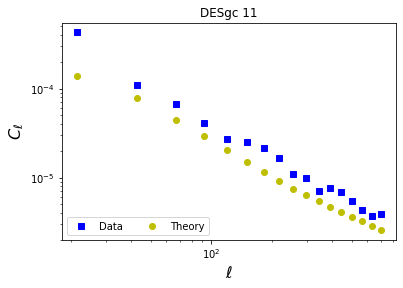

In [18]:
#plt.plot(ell_arr, cl_s1s1[0] -KV_nl_s1s1[0], 'bo-', label='Empirical')
plt.plot(ell_arr, cl_11[0] , 'bs', label='Data')
plt.plot(ell_arr, DES_theory_11 , 'yo', label='Theory')
#plt.plot(ell_arr,Theory_cl_s1s1, 'r--', label='Theory')

#plt.plot(ell_arr, DES_theory_11, 'r--', label='Theory cl_ij')
#plt.plot(ccl_11['ell'], ccl_11['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('DESgc 11')
#plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [19]:
def load_carlos_cl(a, b):
    return np.load('/home/zcapjru/PhD/Data/Carlos_DESgc/cl_DESgc{}_DESgc{}.npz'.format(a,b))
def load_jaime_cl(a, b):
    return np.loadtxt('/home/zcapjru/PhD/Cls/DESgc/DES_cl_{}{}.txt'.format(a,b))
def load_jaime_nl(a, b):
    return np.loadtxt('/home/zcapjru/PhD/Cls/DESgc/DES_nl_{}{}.txt'.format(a,b))

In [20]:
for i in range(1):
    for j in range(5):
        if i <= j:
            carlos_ij = load_carlos_cl(i,j)['cl'][0]
            jaime_ij = load_jaime_cl(i,j)
            if i == j:
                jaime_ij = jaime_ij - load_jaime_nl(i,j)
            diff = abs(carlos_ij - jaime_ij)
            print('for bin_{}{} the max error is {}'.format(i , j, max(diff)))
            
for i in range(5):
    for j in range(5):
        if i == j:
            carlos_ij = load_carlos_cl(i,j)['cl'][0]
            jaime_ij = load_jaime_cl(i,j)
            if i == j:
                jaime_ij = jaime_ij - load_jaime_nl(i,j)
            diff = abs(carlos_ij - jaime_ij)
            print('for bin_{}{} the max error is {}'.format(i , j, max(diff)))

for bin_00 the max error is 3.90042232995165e-13
for bin_01 the max error is 1.0906665924136777e-13
for bin_02 the max error is 1.457305904775533e-13
for bin_03 the max error is 1.387044437097494e-13
for bin_04 the max error is 2.0298421045405763e-13
for bin_00 the max error is 3.90042232995165e-13
for bin_11 the max error is 2.549291886529831e-13
for bin_22 the max error is 6.491392506532447e-14
for bin_33 the max error is 1.1189573573266998e-13
for bin_44 the max error is 3.960437087600823e-13


In [21]:
carlos11 = load_carlos_cl(0,0)
jcl11 = load_jaime_cl(0,0)
jnl11 = load_jaime_nl(0,0)

carlos15 = load_carlos_cl(0,4)
jcl15 = load_jaime_cl(0,4)
#jnl11 = load_jaime_nl(0,4)[0]

carlos55 = load_carlos_cl(4,4)
jcl55 = load_jaime_cl(4,4)
jnl55 = load_jaime_nl(4,4)

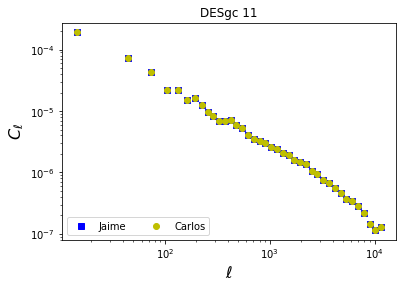

In [22]:
#plt.plot(ell_arr, cl_s1s1[0] -KV_nl_s1s1[0], 'bo-', label='Empirical')
plt.plot(carlos11['ell'], jcl11 - jnl11 , 'bs', label='Jaime')
plt.plot(carlos11['ell'], carlos11['cl'][0] , 'yo', label='Carlos')
#plt.plot(ell_arr,Theory_cl_s1s1, 'r--', label='Theory')

#plt.plot(ell_arr, DES_theory_11, 'r--', label='Theory cl_ij')
#plt.plot(ccl_11['ell'], ccl_11['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('DESgc 11')
#plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

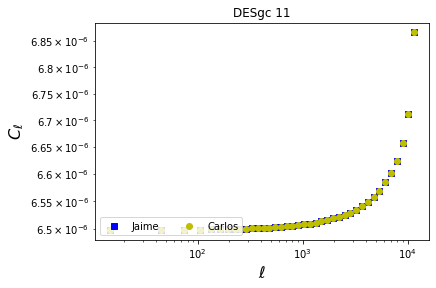

In [23]:
#plt.plot(ell_arr, cl_s1s1[0] -KV_nl_s1s1[0], 'bo-', label='Empirical')
plt.plot(carlos11['ell'], jnl11, 'bs', label='Jaime')
plt.plot(carlos11['ell'], carlos11['nl'][0] , 'yo', label='Carlos')
#plt.plot(ell_arr,Theory_cl_s1s1, 'r--', label='Theory')

#plt.plot(ell_arr, DES_theory_11, 'r--', label='Theory cl_ij')
#plt.plot(ccl_11['ell'], ccl_11['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('DESgc 11')
#plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
#plt.plot(ell_arr, cl_s1s1[0] -KV_nl_s1s1[0], 'bo-', label='Empirical')

plt.plot(carlos15['ell'], jcl15, 'bs', label='Jaime')
plt.plot(carlos15['ell'], carlos15['cl'][0] , 'yo', label='Carlos')
#plt.plot(ell_arr,Theory_cl_s1s1, 'r--', label='Theory')

#plt.plot(ell_arr, DES_theory_11, 'r--', label='Theory cl_ij')
#plt.plot(ccl_11['ell'], ccl_11['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('DESgc 15')
#plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
#plt.plot(ell_arr, cl_s1s1[0] -KV_nl_s1s1[0], 'bo-', label='Empirical')

plt.plot(carlos55['ell'], jnl55, 'bs', label='Jaime')
plt.plot(carlos55['ell'], carlos55['nl'][0] , 'yo', label='Carlos')
#plt.plot(ell_arr,Theory_cl_s1s1, 'r--', label='Theory')

#plt.plot(ell_arr, DES_theory_11, 'r--', label='Theory cl_ij')
#plt.plot(ccl_11['ell'], ccl_11['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('DESgc 55')
#plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
#plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()